In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

In [109]:
jax.config.update('jax_disable_jit', True)

### Define fitness function

In [110]:
fitness_func = lambda x: -jnp.sum((x - 5.0) * (x - 5.0), axis=-1)

In [129]:
num_iterations = 700 # 70000 #70000 #10000
num_dimensions = 10 #100 #1000 #@param {type:"integer"} # try 20 and 100
grid_shape = (500, 500) # (500, 500) 
batch_size = 500 #@param {type:"integer"}
sigma_g = 1. # 0.5 #@param {type:"number"}
minval = -5.12
num_best = 250 #36

def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)
#     return (first_term + second_term)

fitness_func = jax.vmap(rastrigin_scoring)

### Instantiate CMA-ES object

In [130]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions, #2, 
    fitness_function=fitness_func,
    mean_init=jnp.zeros((num_dimensions,)), #jnp.asarray([-1.0, -1.0]),
    init_sigma=sigma_g, #1.0,
    init_step_size=0.5, #0.5,
    delay_eigen_decomposition=True, #False,
)

c1:  0.0077244234
c cov:  0.92902696
Eigen decomposition delay:  0.1687896


### Initialization

In [131]:
state = cmaes.init()
key = jax.random.PRNGKey(0)

Initial cov:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Initial invsqrt cov:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [132]:
cmaes._weights

DeviceArray([2.2378536e-02, 1.9570220e-02, 1.7927460e-02, 1.6761903e-02,
             1.5857827e-02, 1.5119144e-02, 1.4494595e-02, 1.3953587e-02,
             1.3476384e-02, 1.3049511e-02, 1.2663358e-02, 1.2310827e-02,
             1.1986531e-02, 1.1686279e-02, 1.1406751e-02, 1.1145271e-02,
             1.0899648e-02, 1.0668068e-02, 1.0449013e-02, 1.0241196e-02,
             1.0043520e-02, 9.8550413e-03, 9.6749440e-03, 9.5025115e-03,
             9.3371188e-03, 9.1782156e-03, 9.0253083e-03, 8.8779628e-03,
             8.7357890e-03, 8.5984357e-03, 8.4655853e-03, 8.3369548e-03,
             8.2122823e-03, 8.0913315e-03, 7.9738880e-03, 7.8597516e-03,
             7.7487431e-03, 7.6406966e-03, 7.5354557e-03, 7.4328789e-03,
             7.3328358e-03, 7.2352039e-03, 7.1398686e-03, 7.0467256e-03,
             6.9556758e-03, 6.8666274e-03, 6.7794942e-03, 6.6941953e-03,
             6.6106548e-03, 6.5288031e-03, 6.4485720e-03, 6.3698990e-03,
             6.2927241e-03, 6.2169922e-03, 6.142649

### Iterations

In [133]:
%%time

means = [state.mean]
covs = [state.cov_matrix]

for _ in range(num_iterations):
    
    samples, key = cmaes.sample(state, key)
#     state = cmaes.update(state, samples)

    fitnesses = -fitness_func(samples)
    idx_sorted = jnp.argsort(fitnesses)
    sorted_candidates = samples[idx_sorted[: num_best]]

    state = cmaes.update_state(state, sorted_candidates)
    
    stop_condition = cmaes.stop_condition(state)
    print("Step size: ", state.step_size)
    print("Stop condition: ", stop_condition)
    if stop_condition:
        break
    
    means.append(state.mean)
    covs.append(state.cov_matrix)

Inv sqrt cov before:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Eigen condition's value:  False
Inv sqrt cov after:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
tmp_1:  False
Step size:  0.9005419
Stop condition:  False
Inv sqrt cov before:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 

Step size:  1.4849087
Stop condition:  False
Inv sqrt cov before:  [[ 5.47840297e-01 -5.70902936e-02 -3.22088301e-02 -6.66633174e-02
  -3.65394130e-02 -2.94578783e-02 -4.38861623e-02 -1.97677389e-02
  -3.15419994e-02 -2.36975886e-02]
 [-5.70902787e-02  5.40662885e-01  1.41534861e-02  2.23604701e-02
   1.62866116e-02  6.53493265e-03 -1.03731165e-02  1.34472502e-02
   1.44155752e-02  2.95647327e-03]
 [-3.22088450e-02  1.41534880e-02  6.02554977e-01 -3.53502482e-02
   5.11538237e-04  1.67922545e-02 -4.23365608e-02 -2.15280429e-02
  -3.81203443e-02 -3.87905650e-02]
 [-6.66633025e-02  2.23604701e-02 -3.53502631e-02  5.31693995e-01
  -1.60510466e-02 -4.80898097e-02 -6.32572547e-03 -2.71501727e-02
   2.77110226e-02 -3.62173803e-02]
 [-3.65394205e-02  1.62866190e-02  5.11538237e-04 -1.60510167e-02
   5.28609633e-01 -1.17556304e-02 -1.13208666e-02 -6.70279264e-02
  -9.04182345e-03 -1.17345881e-02]
 [-2.94578858e-02  6.53493078e-03  1.67922694e-02 -4.80898097e-02
  -1.17556304e-02  5.45001626e-0

Step size:  1.5756307
Stop condition:  False
Inv sqrt cov before:  [[ 1.1240399  -0.06613318 -0.06803825 -0.10435972 -0.1064945  -0.04269948
   0.0120044   0.0085118  -0.07442928 -0.01655858]
 [-0.06613315  1.2325281  -0.01001448 -0.00877168  0.12925006  0.059591
   0.00295606 -0.04257567  0.00147045 -0.00146932]
 [-0.06803825 -0.01001454  1.4173001  -0.00990772 -0.01808625 -0.02071279
  -0.18009493 -0.07799305 -0.11830224 -0.09269464]
 [-0.10435973 -0.00877168 -0.00990774  1.265327   -0.06235129 -0.16940364
  -0.04185631 -0.03944626  0.02138709 -0.03789685]
 [-0.1064945   0.1292501  -0.01808621 -0.06235129  1.2149513   0.05712661
  -0.06109942 -0.14850348  0.02158493  0.03823002]
 [-0.04269947  0.05959101 -0.02071277 -0.16940363  0.05712662  1.1977102
  -0.05254616 -0.04410821 -0.04036973 -0.08868016]
 [ 0.01200441  0.00295607 -0.18009493 -0.04185631 -0.06109942 -0.05254616
   1.131532   -0.16662602 -0.18689886 -0.09199941]
 [ 0.0085118  -0.04257563 -0.07799305 -0.03944622 -0.14850348

tmp_1:  True
Step size:  1.6033189
Stop condition:  False
Inv sqrt cov before:  [[ 3.7910163  -0.26820043 -0.5945427  -0.6301914  -0.01943279 -0.18408565
   0.11258253 -0.05414028 -0.530617    0.20333606]
 [-0.2682004   4.0890083   0.12003911  0.13922405  0.24474137  0.34960714
   0.16240291 -0.2835072  -0.27780187 -0.3682914 ]
 [-0.5945426   0.12003897  4.416576   -0.09590334  0.19955435 -0.28092378
  -0.70143425 -0.47085395 -0.5232109  -0.64723873]
 [-0.6301913   0.13922393 -0.09590337  4.190912    0.17191446 -0.5231223
  -0.12025559 -0.25915864 -0.13797487 -0.410596  ]
 [-0.01943275  0.24474137  0.1995543   0.17191443  3.524502    0.2999526
  -0.06114715 -0.15864612 -0.07056396  0.07804039]
 [-0.18408562  0.3496069  -0.28092378 -0.5231223   0.29995263  4.474487
  -0.33631486 -0.17422524 -0.41012672 -0.8000616 ]
 [ 0.11258253  0.16240288 -0.70143414 -0.12025559 -0.06114721 -0.33631486
   4.5800834  -0.7378479  -1.0175804  -0.39682716]
 [-0.05414034 -0.2835072  -0.47085395 -0.25915858

Step size:  2.5539417
Stop condition:  False
Inv sqrt cov before:  [[20.2044     -0.6102792  -2.1833982  -0.99459505 -0.8024399  -1.1962678
  -0.9966586  -1.0445272  -0.33578813  1.6297077 ]
 [-0.6102792  17.863052    0.8920064  -1.8512199   1.3269886   1.756961
   1.8443903  -3.3819385  -1.3235167  -4.2356167 ]
 [-2.1833982   0.8920059  17.54563    -0.4421763   1.7174902  -3.28996
  -2.434298   -3.4758894  -1.7999494  -2.72259   ]
 [-0.99459505 -1.8512199  -0.4421768  20.967012    1.2268102  -1.5318367
  -0.24531515 -3.6224113  -1.7727088  -3.5471215 ]
 [-0.80244     1.3269886   1.71749     1.2268102  11.765278    1.930022
  -1.0409027  -1.4204994  -0.28121555  2.0633938 ]
 [-1.1962676   1.756961   -3.28996    -1.5318364   1.930022   17.292538
   0.7418966   2.050657   -1.9188676  -6.728718  ]
 [-0.9966584   1.84439    -2.4342985  -0.24531552 -1.0409027   0.7418966
  21.669966   -2.6489565  -3.7084398  -2.9158046 ]
 [-1.0445268  -3.3819387  -3.475889   -3.6224115  -1.4204994   2.05065

Step size:  3.2269394
Stop condition:  False
Inv sqrt cov before:  [[ 9.01688766e+01 -8.29496980e-02 -1.02054958e+01 -7.23236227e+00
  -9.68578529e+00 -1.61515415e+00 -8.45509720e+00 -7.79810286e+00
   4.14986420e+00  2.81959176e+00]
 [-8.29496384e-02  8.09325485e+01 -2.64144850e+00 -1.93218040e+01
   1.58328533e+00  9.47158432e+00  3.20790005e+00 -1.15250454e+01
  -4.53475285e+00 -1.47094736e+01]
 [-1.02054958e+01 -2.64144874e+00  9.10213242e+01 -1.71431541e+00
   9.07821083e+00 -1.38621435e+01 -1.03014889e+01 -1.84860706e+01
  -1.17910938e+01 -7.96021843e+00]
 [-7.23236227e+00 -1.93218040e+01 -1.71431541e+00  1.03530602e+02
   2.05108643e+00 -8.02195740e+00 -7.65921974e+00 -1.57839670e+01
  -8.18461323e+00 -2.06552792e+01]
 [-9.68578529e+00  1.58328390e+00  9.07820988e+00  2.05108690e+00
   5.34388962e+01  1.07086096e+01 -1.88238316e+01 -7.13280869e+00
   2.00015879e+00  9.30701637e+00]
 [-1.61515307e+00  9.47158432e+00 -1.38621454e+01 -8.02195454e+00
   1.07086105e+01  9.28691559e+0

Step size:  3.8482296
Stop condition:  False
Inv sqrt cov before:  [[ 545.0272       2.479177   -44.684635   -69.31472    -82.7211
   -15.7703705  -87.77796    -47.702568    42.356754    -4.9459615]
 [   2.4791732  446.56653      5.0531087 -152.83173     12.000509
    51.370743   -10.355798   -91.00451    -42.258034   -61.52816  ]
 [ -44.68463      5.053117   559.00305      1.031786    69.76282
   -81.63309    -32.99723   -123.15319   -102.12689    -83.732544 ]
 [ -69.31473   -152.83173      1.031786   646.30554     16.754396
   -83.75805    -70.022995  -152.19324    -47.574875  -131.3219   ]
 [ -82.721085    12.000502    69.7628      16.754404   319.12842
    43.75234   -169.5234     -41.92872     27.72685     78.44221  ]
 [ -15.7703705   51.37074    -81.6331     -83.758064    43.752357
   564.08594     58.6356      66.38809    -57.555107  -213.17935  ]
 [ -87.77797    -10.35579    -32.997234   -70.023026  -169.5234
    58.635593   503.8238     -83.494675   -60.71855   -139.11597  ]
 

tmp_1:  True
Step size:  4.4190702
Stop condition:  False
Inv sqrt cov before:  [[11601.753     172.95908  -107.42144 -1904.58    -1937.9968    701.62354
  -2475.3843  -1310.9579   1185.7694   -418.68588]
 [  172.95932 10162.479      39.77994 -3471.9802    880.192    1199.042
   -676.5058  -2159.27     -428.5349  -1889.4734 ]
 [ -107.42133    39.77994 13237.589    -432.8589   1809.1525  -3205.1165
    183.99416 -3751.7214  -2491.5679  -1703.8994 ]
 [-1904.5802  -3471.9802   -432.85962 15194.499      56.50858 -1931.9491
  -1304.6434  -4285.8623  -1108.8827  -3138.1125 ]
 [-1937.9968    880.192    1809.1525     56.50852  5999.9116   1455.5334
  -4236.442    -747.08234  1307.2727   2070.0693 ]
 [  701.62366  1199.042   -3205.1165  -1931.9495   1455.5334  12578.349
   1444.0372   1330.3616  -1935.8015  -4572.8813 ]
 [-2475.3843   -676.50574   183.99403 -1304.6431  -4236.442    1444.0375
  10256.406   -1749.1139   -541.9698  -3037.292  ]
 [-1310.9579  -2159.2698  -3751.7214  -4285.863    -7

Step size:  4.8165827
Stop condition:  False
Inv sqrt cov before:  [[ 328864.6       4234.6055    2716.3816  -43791.367   -53229.82
    17696.42    -79674.59    -33606.363    26390.152   -12705.464 ]
 [   4234.5977  266703.22      7106.6206  -85789.49     29939.248
    41600.84    -16767.982   -65533.35     -8966.249   -59744.492 ]
 [   2716.3777    7106.6304  366812.2      -7609.75     47027.543
   -92883.67      6263.4966 -114580.086   -72394.01    -52551.645 ]
 [ -43791.367   -85789.484    -7609.7407  428268.75     11209.425
   -67572.01    -52192.99   -141488.94    -29221.38    -73159.086 ]
 [ -53229.83     29939.246    47027.543    11209.42    173291.48
    50000.992  -123155.89    -32465.693    46805.48     58973.67  ]
 [  17696.42     41600.84    -92883.67    -67572.01     50001.
   356225.97     31014.238    54008.324   -69775.234  -115607.945 ]
 [ -79674.59    -16767.982     6263.4927  -52192.98   -123155.89
    31014.246   291857.28    -38065.418   -14782.1045  -74886.18  ]
 

tmp_1:  True
Step size:  5.270271
Stop condition:  False
Inv sqrt cov before:  [[ 2921094.8     285751.1     -38648.754  -529713.7    -466540.3
    474337.22   -738963.75   -233666.03    -48566.207  -192530.47 ]
 [  285751.1    2785255.     -285265.1    -575000.7      99111.64
     80000.57   -453164.4    -262918.44   -292951.     -441222.9  ]
 [  -38648.758  -285265.1    4022075.     -207809.44    636057.4
   -804438.6    -111852.1    -412981.7    -616128.4    -857410.44 ]
 [ -529713.56   -575000.7    -207809.61   3513693.2     193181.89
   -220647.33   -626618.56   -478118.53   -520809.2    -801789.5  ]
 [ -466540.3      99111.68    636057.4     193181.94   1688659.8
    242818.05  -1292526.2     -92556.99    603054.56    507355.88 ]
 [  474337.2      80000.57   -804438.7    -220647.33    242818.05
   2537630.2     228085.42   -177670.19   -529806.7    -609103.2  ]
 [ -738963.7    -453164.34   -111852.1    -626618.56  -1292526.1
    228085.42   3071404.5    -764447.94    -17842.773  

In [134]:
fitnesses

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [135]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * 5.12)
# worst_objective = rastrigin_scoring(jnp.zeros(num_dimensions))
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

(fitnesses - worst_objective) * 100 / (best_objective - worst_objective)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [136]:
means[-1]

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

### Visualization

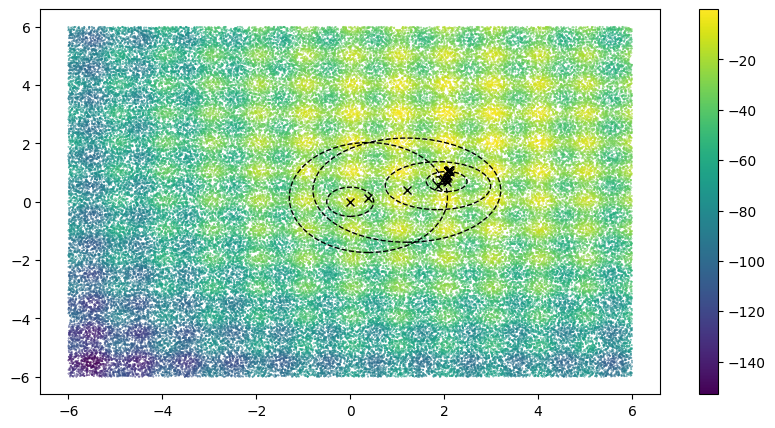

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))

# sample points to show fitness landscape
x = jax.random.uniform(key, minval=-6, maxval=6, shape=(100000, 2))
f_x = fitness_func(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
for mean, cov in zip(means, covs):
#     print("Mean: ", mean)
#     print("Covariance: ", cov)
#     print("Covariance: ", cov[0])
#     print("Covariance: ", cov[1])
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')

In [17]:
N = 4

pc = jnp.zeros((N,1))
ps = jnp.zeros((N,1))  # evolution paths for C and sigma
B = jnp.eye(N,N)    # B defines the coordinate system
D = jnp.ones((N,1))      # diagonal D defines the scaling
C = B * jnp.diag(D**2) * B.T     # covariance matrix C
invsqrtC = B * jnp.diag(D**(-1)) * B.T

In [18]:
pc

DeviceArray([[0.],
             [0.],
             [0.],
             [0.]], dtype=float32)

In [19]:
ps

DeviceArray([[0.],
             [0.],
             [0.],
             [0.]], dtype=float32)

In [20]:
B

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [21]:
D

DeviceArray([[1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [20]:
jnp.diag(D)

DeviceArray([1.], dtype=float32)

In [33]:
D**2

DeviceArray([[1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [29]:
B * jnp.diag(D**2) * B.T

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [30]:
B * jnp.diag(D**(-1)) * B.T

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [34]:
C

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [35]:
jnp.triu(C)

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [39]:
A = jnp.array(
[[1, 2, 3, 4],
 [5, 6, 7, 8],
 [9, 10, 11, 12],
 [13, 14, 15, 16]])

In [40]:
A

DeviceArray([[ 1,  2,  3,  4],
             [ 5,  6,  7,  8],
             [ 9, 10, 11, 12],
             [13, 14, 15, 16]], dtype=int32)

In [41]:
jnp.triu(A)

DeviceArray([[ 1,  2,  3,  4],
             [ 0,  6,  7,  8],
             [ 0,  0, 11, 12],
             [ 0,  0,  0, 16]], dtype=int32)

In [21]:
weights = jnp.array([1, 2, 3, 4, 5])
jnp.diag(weights)

DeviceArray([[1, 0, 0, 0, 0],
             [0, 2, 0, 0, 0],
             [0, 0, 3, 0, 0],
             [0, 0, 0, 4, 0],
             [0, 0, 0, 0, 5]], dtype=int32)